In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$

### Representing complex numbers

To represent the complex numbers, I will use an array of two float, where the first element represents the real part and the second element the imaginary part.

In [2]:
def square(x):
    result = [0, 0]

    result[0] = x[0]**2 - x[1]**2
    result[1] = 2 * x[0] * x[1]

    return result


def compute(c, z):
    """Compute z^2 + c"""
    z_square = square(z)
    return [c[0] + z_square[0] , c[1] + z_square[1]]


def isInMandelbrotSet(c, z=[0, 0], max_iter=1000, n=0) -> bool:
    if z[0]**2 + z[1]**2 > 4:
        return False
    
    if n==max_iter:
        return True

    return isInMandelbrotSet(c, compute(c, z), max_iter, n+1)


In [3]:
print(f"Is [-1,0] in the set?: {isInMandelbrotSet([-1, 0])}")  # should be true
print(f"Is [1,0] in the set?: {isInMandelbrotSet([1, 0])}")  # should be false

Is [-1,0] in the set?: True
Is [1,0] in the set?: False


### Creating a dataset

In [4]:
# Define the range for the real and imaginary parts
real_range = np.linspace(-2, 1, 50)
imag_range = np.linspace(-1.5, 1.5, 50)

data = []
for a in real_range:
    for b in imag_range:
        c = [a, b]
        is_in_set = isInMandelbrotSet(c)
        data.append({
            'real': a,
            'imag': b,
            'in_mandelbrot_set': is_in_set
        })

df = pd.DataFrame(data)

In [5]:
df

,real,imag,in_mandelbrot_set
0,-2.0,-1.500000,False
1,-2.0,-1.438776,False
2,-2.0,-1.377551,False
3,-2.0,-1.316327,False
4,-2.0,-1.255102,False
...,...,...,...
2495,1.0,1.255102,False
2496,1.0,1.316327,False
2497,1.0,1.377551,False
2498,1.0,1.438776,False


As we can see, the dataset is heavily imbalanced. It is very important to remember this, because it will affect the way we measure the performance pf the model and the way we split the dataset.

In [6]:
df['in_mandelbrot_set'].value_counts()

in_mandelbrot_set
False    2094
True      406
Name: count, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["in_mandelbrot_set"])
y = df["in_mandelbrot_set"]

# Using stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)


### Neural Network

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layers=3):
        super().__init__()
        
        layers = [
            nn.Linear(2, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        return self.sigmoid_layer(x)

### Training Loop

In [9]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCELoss()):

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")


    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

def test(model, X_test, y_test, threshold=0.5):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        y_prob_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_prob_tensor > threshold).float()

        y_true_np = y_test_tensor.numpy()
        y_pred_np = y_pred.numpy()
        y_prob_np = y_prob_tensor.numpy()

        # Calculate metrics
        auc = roc_auc_score(y_true_np, y_prob_np)
        print(f"Test AUC: {auc:.4f}\n")
        
        accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_test_tensor.numpy(), y_pred.numpy()))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()))

        f1 = f1_score(y_true_np, y_pred_np, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "auc": auc,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
    
    return report

### Choosing Model

We will use the validation set to test the different models and choose which one we want to use.

Training model: 1_hidden_layer
Epoch: 1, Train Loss: 0.7533611479927512, Val Loss: 0.7006562709808349
Epoch: 2, Train Loss: 0.6463114679560942, Val Loss: 0.6009489909807841
Epoch: 3, Train Loss: 0.5522692094830906, Val Loss: 0.5169491092363994
Epoch: 4, Train Loss: 0.47811299310011024, Val Loss: 0.45668022394180297
Epoch: 5, Train Loss: 0.4291888272411683, Val Loss: 0.4187999637921651
Epoch: 6, Train Loss: 0.39838157864177925, Val Loss: 0.39508869727452595
Epoch: 7, Train Loss: 0.3812011110081392, Val Loss: 0.38334295988082884
Epoch: 8, Train Loss: 0.3718560294894611, Val Loss: 0.37584553003311155
Epoch: 9, Train Loss: 0.36512217185076545, Val Loss: 0.36973917881647744
Epoch: 10, Train Loss: 0.35921580375993956, Val Loss: 0.36404690901438397
Epoch: 11, Train Loss: 0.3535576693801319, Val Loss: 0.358468132019043
Epoch: 12, Train Loss: 0.3479464995510438, Val Loss: 0.3529427893956502
Epoch: 13, Train Loss: 0.34233630646677576, Val Loss: 0.34740098237991335
Epoch: 14, Train Loss: 0.336698

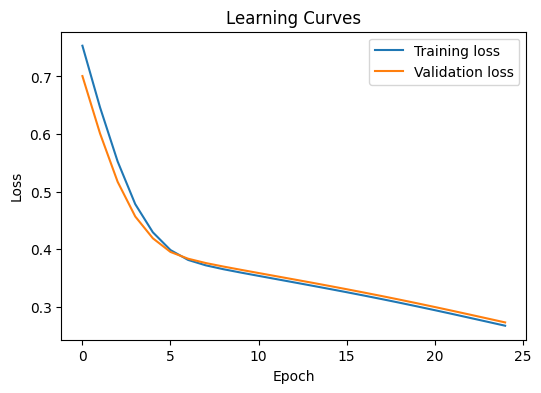

Test AUC: 0.9738

Test Accuracy: 0.8367

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       251
         1.0       0.00      0.00      0.00        49

    accuracy                           0.84       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.70      0.84      0.76       300

Confusion Matrix:
[[251   0]
 [ 49   0]]
Training model: 3_hidden_layers
Epoch: 1, Train Loss: 0.6882122401630177, Val Loss: 0.6707153534889221
Epoch: 2, Train Loss: 0.6484511329145992, Val Loss: 0.6219867936770122


/home/carlos/Mandelbrot-set-neural-net/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/carlos/Mandelbrot-set-neural-net/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/carlos/Mandelbrot-set-neural-net/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Epoch: 3, Train Loss: 0.5832931807461907, Val Loss: 0.5391875259081522
Epoch: 4, Train Loss: 0.47886329889297485, Val Loss: 0.42920139074325564
Epoch: 5, Train Loss: 0.3930606563652263, Val Loss: 0.37990347544352215
Epoch: 6, Train Loss: 0.36088413736399483, Val Loss: 0.35895145416259766
Epoch: 7, Train Loss: 0.3411520623810151, Val Loss: 0.3406846396128337
Epoch: 8, Train Loss: 0.32068496328942914, Val Loss: 0.3189925813674927
Epoch: 9, Train Loss: 0.29786180182414895, Val Loss: 0.29657307744026185
Epoch: 10, Train Loss: 0.27481235462076525, Val Loss: 0.2741998819510142
Epoch: 11, Train Loss: 0.25273009300231936, Val Loss: 0.2529324324925741
Epoch: 12, Train Loss: 0.23236304800300037, Val Loss: 0.2332619293530782
Epoch: 13, Train Loss: 0.21349267533596825, Val Loss: 0.21480849782625835
Epoch: 14, Train Loss: 0.19600685496540632, Val Loss: 0.19765609622001648
Epoch: 15, Train Loss: 0.17947557824499466, Val Loss: 0.18118722180525462
Epoch: 16, Train Loss: 0.16455920293927193, Val Loss: 

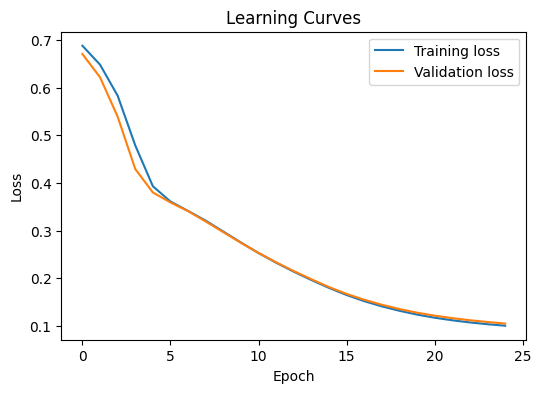

Test AUC: 0.9906

Test Accuracy: 0.9567

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       251
         1.0       0.88      0.86      0.87        49

    accuracy                           0.96       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.96      0.96      0.96       300

Confusion Matrix:
[[245   6]
 [  7  42]]
Training model: 5_hidden_layers
Epoch: 1, Train Loss: 0.6908677750475266, Val Loss: 0.6632749398549398
Epoch: 2, Train Loss: 0.6144770526885986, Val Loss: 0.5396385312080383
Epoch: 3, Train Loss: 0.44681351928149954, Val Loss: 0.39767823457717894
Epoch: 4, Train Loss: 0.3807668696782168, Val Loss: 0.378747394879659
Epoch: 5, Train Loss: 0.36058753469411065, Val Loss: 0.3573409032821655
Epoch: 6, Train Loss: 0.3361690173429601, Val Loss: 0.33032411575317383
Epoch: 7, Train Loss: 0.30535645754898294, Val Loss: 0.29603822072347
Epoch: 8, Train Loss: 0.2691744984072

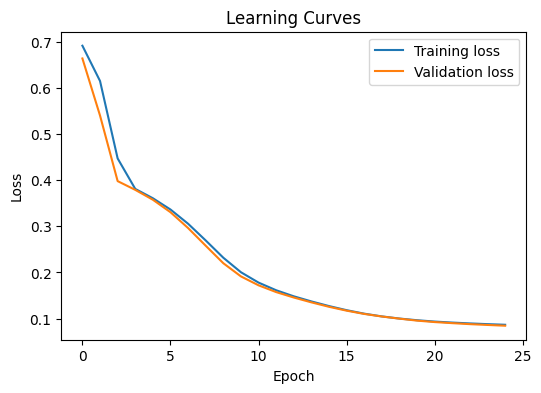

Test AUC: 0.9941

Test Accuracy: 0.9700

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       251
         1.0       0.87      0.96      0.91        49

    accuracy                           0.97       300
   macro avg       0.93      0.97      0.95       300
weighted avg       0.97      0.97      0.97       300

Confusion Matrix:
[[244   7]
 [  2  47]]
Training model: 7_hidden_layers
Epoch: 1, Train Loss: 0.6676860374562881, Val Loss: 0.6541349832216898
Epoch: 2, Train Loss: 0.6373250854716581, Val Loss: 0.6128879268964131
Epoch: 3, Train Loss: 0.5274752653696958, Val Loss: 0.41755281925201415
Epoch: 4, Train Loss: 0.3986144053936005, Val Loss: 0.3948644288380941
Epoch: 5, Train Loss: 0.38558032845749574, Val Loss: 0.3828878172238668
Epoch: 6, Train Loss: 0.3738540395568399, Val Loss: 0.3705770476659139
Epoch: 7, Train Loss: 0.3611466524180244, Val Loss: 0.3568659138679504
Epoch: 8, Train Loss: 0.3468299457606

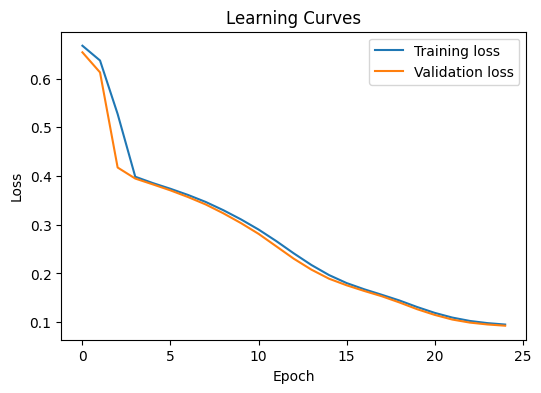

Test AUC: 0.9908

Test Accuracy: 0.9633

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       251
         1.0       0.85      0.94      0.89        49

    accuracy                           0.96       300
   macro avg       0.92      0.95      0.94       300
weighted avg       0.97      0.96      0.96       300

Confusion Matrix:
[[243   8]
 [  3  46]]
Training model: 9_hidden_layers
Epoch: 1, Train Loss: 0.7148552733309129, Val Loss: 0.7033229613304138
Epoch: 2, Train Loss: 0.6862001810354345, Val Loss: 0.6631510448455811
Epoch: 3, Train Loss: 0.5735105367267833, Val Loss: 0.41724977334340413
Epoch: 4, Train Loss: 0.3841271731082131, Val Loss: 0.3765981427828471
Epoch: 5, Train Loss: 0.3642666664544274, Val Loss: 0.36030776262283326
Epoch: 6, Train Loss: 0.34724800088826346, Val Loss: 0.34306912978490195
Epoch: 7, Train Loss: 0.3289809803752338, Val Loss: 0.32442744572957355
Epoch: 8, Train Loss: 0.3090763739

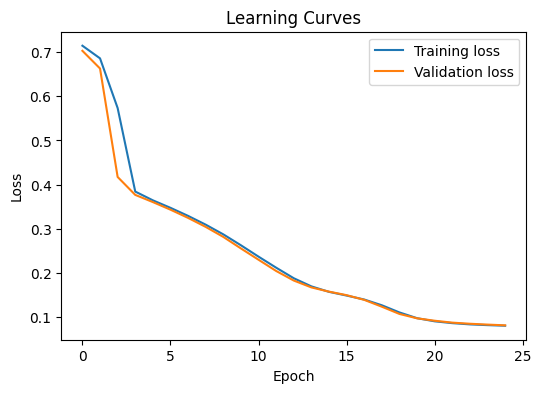

Test AUC: 0.9937

Test Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       251
         1.0       0.88      0.92      0.90        49

    accuracy                           0.97       300
   macro avg       0.93      0.95      0.94       300
weighted avg       0.97      0.97      0.97       300

Confusion Matrix:
[[245   6]
 [  4  45]]


In [13]:
model_configs = {
    "1_hidden_layer": NeuralNet(num_hidden_layers=1),
    "3_hidden_layers": NeuralNet(num_hidden_layers=3),
    "5_hidden_layers": NeuralNet(num_hidden_layers=5),
    "7_hidden_layers": NeuralNet(num_hidden_layers=7),
    "9_hidden_layers": NeuralNet(num_hidden_layers=9),
}

results = {}

for name, model in model_configs.items():
    print(f"Training model: {name}")
    
    # Train the model
    trained_model = train(model, X_train, y_train, X_val, y_val, num_epoch=25)
    
    # Test the model and store the returned metrics
    results[name] = test(trained_model, X_val, y_val)

In [14]:
results_df = pd.DataFrame(results).T
results_df

,accuracy,f1_score_positive,auc,true_positives,false_positives,true_negatives,false_negatives
1_hidden_layer,0.836667,0.000000,0.973819,0.0,0.0,251.0,49.0
3_hidden_layers,0.956667,0.865979,0.990568,42.0,6.0,245.0,7.0
5_hidden_layers,0.970000,0.912621,0.994065,47.0,7.0,244.0,2.0
7_hidden_layers,0.963333,0.893204,0.990812,46.0,8.0,243.0,3.0
9_hidden_layers,0.966667,0.900000,0.993658,45.0,6.0,245.0,4.0


### Test the chosen model

Test it on the test set

Epoch: 1, Train Loss: 0.6748959580589743, Val Loss: 0.6454484367370605
Epoch: 2, Train Loss: 0.5803875079575707, Val Loss: 0.4800082580248515
Epoch: 3, Train Loss: 0.41727430028073925, Val Loss: 0.39771042903264364
Epoch: 4, Train Loss: 0.38667057661449206, Val Loss: 0.38491739908854167
Epoch: 5, Train Loss: 0.37286652731544834, Val Loss: 0.37092590967814126
Epoch: 6, Train Loss: 0.3565517879058333, Val Loss: 0.35414172410964967
Epoch: 7, Train Loss: 0.3368276657076443, Val Loss: 0.33329183896382647
Epoch: 8, Train Loss: 0.3124014991521835, Val Loss: 0.3065548380215963
Epoch: 9, Train Loss: 0.28189992303357403, Val Loss: 0.273806791305542
Epoch: 10, Train Loss: 0.24765453247463, Val Loss: 0.23721399148305258
Epoch: 11, Train Loss: 0.21472432075177922, Val Loss: 0.20759458939234415
Epoch: 12, Train Loss: 0.1904655849407701, Val Loss: 0.18609431028366089
Epoch: 13, Train Loss: 0.1719462448270882, Val Loss: 0.16924292206764222
Epoch: 14, Train Loss: 0.15756540430819288, Val Loss: 0.155991

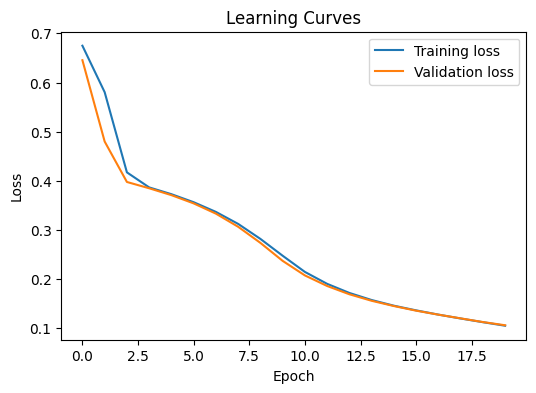

Test AUC: 0.9905

Test Accuracy: 0.9640

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       419
         1.0       0.85      0.94      0.89        81

    accuracy                           0.96       500
   macro avg       0.92      0.95      0.94       500
weighted avg       0.97      0.96      0.96       500

Confusion Matrix:
[[406  13]
 [  5  76]]


In [17]:
model = NeuralNet(num_hidden_layers=5)

model = train(model, X_train, y_train, X_val, y_val)
report = test(model, X_test, y_test)